In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

import geomstats.backend as gs
import matplotlib.pyplot as plt
import torch


import default_config
from datasets.synthetic import get_synth_immersion
from main_eval import get_model_immersion
from main_eval import compute_extrinsic_curvature
from main_eval import plot_curvature_profile

INFO: NumExpr defaulting to 4 threads.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Evaluate Synthetic Data

## From analytic form of immersion

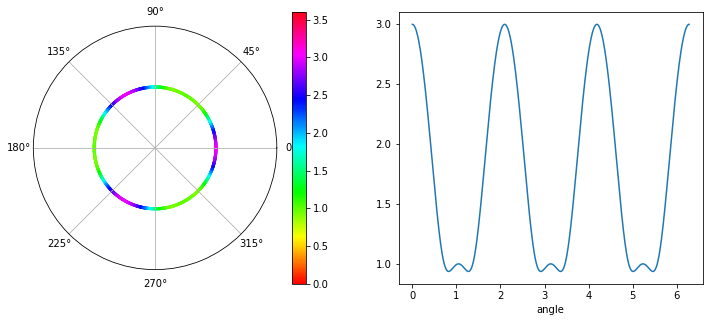

In [3]:
immersion = get_synth_immersion(
    radius=default_config.radius,
    n_wiggles=default_config.n_wiggles,
    amp_wiggles=default_config.amp_wiggles,
    embedding_dim=default_config.embedding_dim,
    rot=default_config.rot,
)

angles = gs.linspace(0, 2 * gs.pi, 1000)


mean_curvature_synth, mean_curvature_norm_synth = compute_extrinsic_curvature(
    angles, immersion, default_config.embedding_dim
)
plot_curvature_profile(angles, mean_curvature_norm_synth)


## Learned immersion via VAE

### Load model

In [8]:
model_filename = "/Users/franciscoacosta/Desktop/code/neuralgeom/neuralgeom/results/trained_models/wiggles_2022-09-09 02:21:00_model.pt"

model = torch.load(model_filename)

model.eval()


VAE(
  (encoder_fc): Linear(in_features=2, out_features=400, bias=True)
  (encoder_linears): ModuleList(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=400, bias=True)
  )
  (fc_z_mu): Linear(in_features=400, out_features=2, bias=True)
  (fc_z_logvar): Linear(in_features=400, out_features=1, bias=True)
  (decoder_fc): Linear(in_features=2, out_features=400, bias=True)
  (decoder_linears): ModuleList(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=400, bias=True)
  )
  (fc_x_mu): Linear(in_features=400, out_features=2, bias=True)
)

### Compare reconstruction with inputs

Dataset shape: torch.Size([1000, 2]).


/Users/franciscoacosta/Desktop/code/neuralgeom/neuralgeom/notebooks/../datasets/utils.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_torch = torch.tensor(dataset)


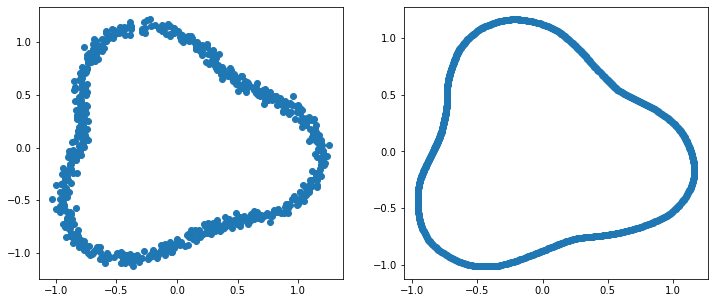

In [9]:
from datasets import utils

dataset_torch, labels, train_loader, test_loader = utils.load(default_config)

x_data = [train_loader.dataset[i][0][0] for i in range(700)]
y_data = [train_loader.dataset[i][0][1] for i in range(700)]

angles = torch.linspace(0, 2 * gs.pi, 1000)
z = torch.stack([torch.cos(angles), torch.sin(angles)], axis=-1)

rec = model.decode(z)

x_rec = rec[0][:, 0].cpu().detach().numpy()
y_rec = rec[0][:, 1].cpu().detach().numpy()

plt.figure(figsize=(12, 5))

ax_data = plt.subplot(1, 2, 1)
sc_data = ax_data.scatter(x_data, y_data)

ax_rec = plt.subplot(1, 2, 2)

sc_rec = ax_rec.scatter(x_rec, y_rec)


### Visualize Latent Space

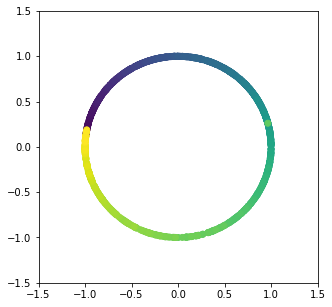

In [10]:
_, posterior_params = model(dataset_torch)

z, _, _ = model.reparameterize(posterior_params)


plt.figure(figsize=(5, 5))
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

z0 = z[:, 0].cpu().detach().numpy()
z1 = z[:, 1].cpu().detach().numpy()

plt.scatter(z0, z1, c=labels["angles"])


### Visualize learned curvature

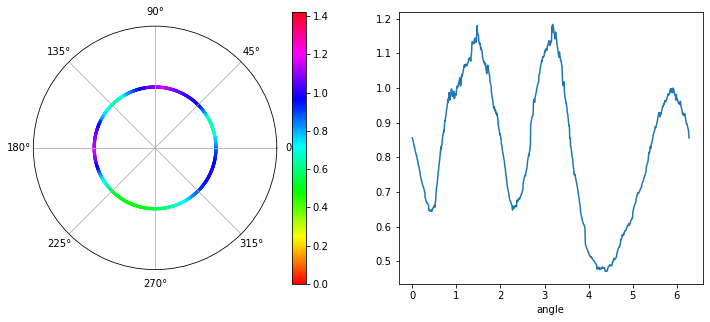

In [11]:
from datasets.synthetic import get_synth_immersion

angles = gs.linspace(0, 2 * gs.pi, 1000)

immersion = get_model_immersion(model)

mean_curvature, mean_curvature_norm = compute_extrinsic_curvature(
    angles, immersion, default_config.embedding_dim
)

plot_curvature_profile(angles, mean_curvature_norm)


## Analysis: Analytical vs Learned

scaling factor: 2.133091926574707


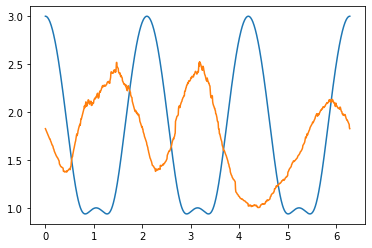

In [36]:
scaling = float(sum(mean_curvature_norm_synth) / sum(mean_curvature_norm))

print("scaling factor: " + str(scaling))

plt.plot(angles, mean_curvature_norm_synth)
plt.plot(angles, scaling * mean_curvature_norm)


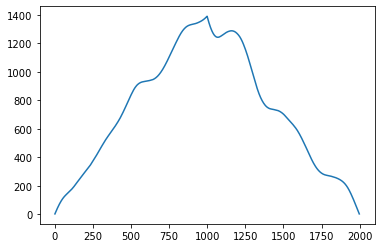

In [37]:
import scipy.signal

cross_corr = scipy.signal.correlate(mean_curvature_norm, mean_curvature_norm_synth)

plt.plot(cross_corr)


In [33]:
period = 2 * gs.pi / 3
dt = torch.linspace(-angles[-1], angles[-1], 2 * 1000 - 1)
recovered_time_shift = dt[cross_corr.argmax()]
